In [1]:
pip install cython


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mrmr_selection


Note: you may need to restart the kernel to use updated packages.



Highly correlated features with correlation above 0.9:
PacketTimeVariance: {'Duration': 0.900179438008312, 'PacketTimeStandardDeviation': 0.9364922772073432}
PacketTimeStandardDeviation: {'Duration': 0.959332736172548, 'PacketTimeVariance': 0.9364922772073432, 'PacketTimeMean': 0.912010526664618}
PacketTimeMean: {'Duration': 0.9221392249642792, 'PacketTimeStandardDeviation': 0.912010526664618, 'PacketTimeMedian': 0.9624257368840671}
PacketTimeMedian: {'PacketTimeMean': 0.9624257368840671}
ResponseTimeTimeMedian: {'ResponseTimeTimeMean': 0.941252581089641}
ResponseTimeTimeSkewFromMode: {'ResponseTimeTimeSkewFromMedian': 0.9398229249711236}

Highly correlated features removed:
         PacketTimeVariance  PacketTimeStandardDeviation  PacketTimeMean  \
0                  1.399133                     1.819915        2.309717   
1                  1.502126                     1.888008        2.760717   
2                  3.270650                     2.855232        2.637593   
3          

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.20it/s]



Selected features using MRMR: ['Duration', 'PacketLengthVariance', 'FlowBytesSent', 'PacketTimeSkewFromMedian', 'PacketLengthMode', 'ResponseTimeTimeMean', 'ResponseTimeTimeSkewFromMedian', 'PacketLengthCoefficientofVariation', 'ResponseTimeTimeCoefficientofVariation', 'PacketTimeMode', 'ResponseTimeTimeMode', 'PacketLengthMean', 'PacketLengthMedian', 'PacketTimeCoefficientofVariation', 'FlowReceivedRate', 'PacketLengthStandardDeviation', 'PacketLengthSkewFromMode', 'ResponseTimeTimeStandardDeviation', 'PacketTimeSkewFromMode', 'FlowBytesReceived']

Cross-validation scores: [0.91582844 0.99811076 0.99967442 0.99974724 0.99917747]
Mean cross-validation score: 0.9825076654984768
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.8s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.8s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.8s
[CV] END 

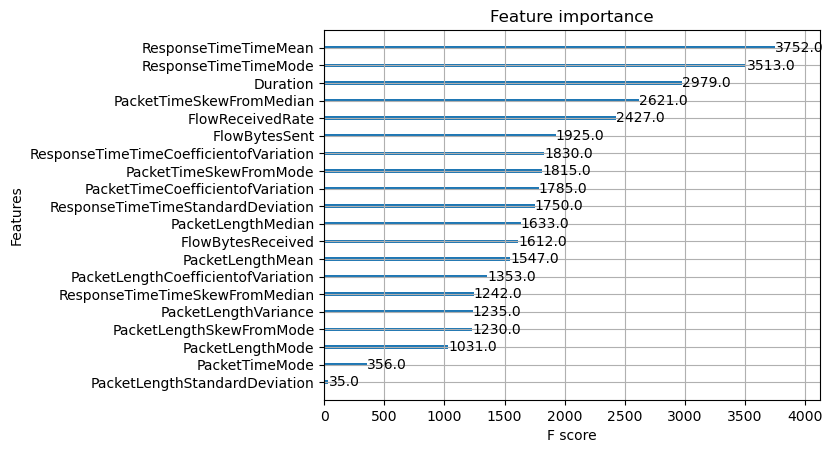

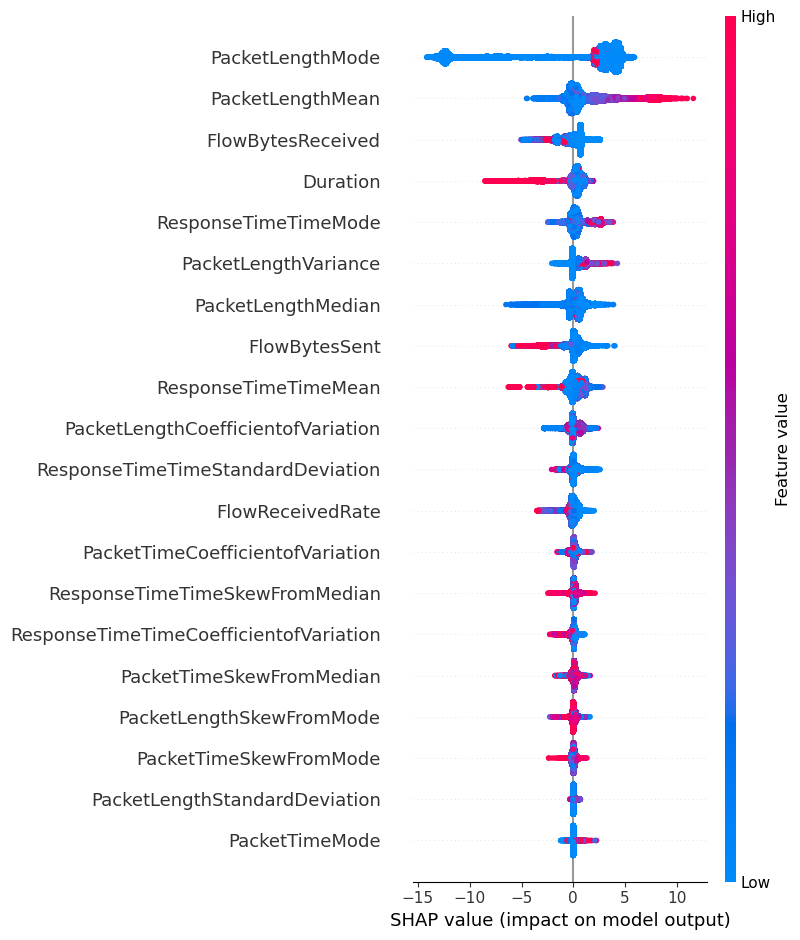

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import shap
from mrmr import mrmr_classif

# Load the datasets
doh_data = pd.read_csv('l1-doh.csv')
nondoh_data = pd.read_csv('l1-nondoh.csv')

# Add labels to the datasets
doh_data['Label'] = 'DoH'  # Label for DoH traffic
nondoh_data['Label'] = 'NonDoH'  # Label for non-DoH traffic

# Combine the datasets
data = pd.concat([doh_data, nondoh_data], ignore_index=True)

# Drop unnecessary columns
columns_to_drop = ['SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort', 'TimeStamp']
data = data.drop(columns_to_drop, axis=1)

# Handle non-numeric values and unnecessary columns
numeric_columns = ['Duration', 'FlowBytesSent', 'FlowSentRate', 'FlowBytesReceived', 'FlowReceivedRate', 
                   'PacketLengthVariance', 'PacketLengthStandardDeviation', 'PacketLengthMean', 'PacketLengthMedian', 
                   'PacketLengthMode', 'PacketLengthSkewFromMedian', 'PacketLengthSkewFromMode', 
                   'PacketLengthCoefficientofVariation', 'PacketTimeVariance', 'PacketTimeStandardDeviation', 
                   'PacketTimeMean', 'PacketTimeMedian', 'PacketTimeMode', 'PacketTimeSkewFromMedian', 
                   'PacketTimeSkewFromMode', 'PacketTimeCoefficientofVariation', 'ResponseTimeTimeVariance', 
                   'ResponseTimeTimeStandardDeviation', 'ResponseTimeTimeMean', 'ResponseTimeTimeMedian', 
                   'ResponseTimeTimeSkewFromMedian', 'ResponseTimeTimeSkewFromMode', 
                   'ResponseTimeTimeCoefficientofVariation']

data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Handle missing values with imputation (mean strategy)
imputer = SimpleImputer(strategy='mean')
data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

# Separate features and target
X = data.drop('Label', axis=1)
y = data['Label']

# Encode categorical target variable 'Label'
le = LabelEncoder()
y = le.fit_transform(y)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Calculate correlation matrix
correlation_matrix = X_scaled_df.corr()

# Identify highly correlated features (threshold > 0.9)
correlation_threshold = 0.9
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > correlation_threshold)]

# Display highly correlated features
print(f"\nHighly correlated features with correlation above {correlation_threshold}:")
for feature in highly_correlated_features:
    correlated_values = correlation_matrix[feature][correlation_matrix[feature].abs() > correlation_threshold].drop(feature)
    print(f"{feature}: {correlated_values.to_dict()}")

# Drop highly correlated features
removed_features = X_scaled_df[highly_correlated_features]
X_scaled_df = X_scaled_df.drop(columns=highly_correlated_features)

# Check if any features are left
if X_scaled_df.shape[1] == 0:
    raise ValueError("No features left after removing highly correlated features. Adjust correlation threshold.")

print(f"\nHighly correlated features removed:")
print(removed_features)

# Perform MRMR feature selection
selected_features = mrmr_classif(X_scaled_df, y, K=20)  # Adjust K as needed
print('\nSelected features using MRMR:', selected_features)

# Reduce the dataset to the selected features
X_selected_df = X_scaled_df[selected_features]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_df, y, test_size=0.3, random_state=42)

# Cross-validation
scores = cross_val_score(XGBClassifier(random_state=42), X_selected_df, y, cv=5, scoring='accuracy')
print(f'\nCross-validation scores: {scores}')
print(f'Mean cross-validation score: {scores.mean()}')

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

print(f'\nBest parameters: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_}')

# Train the XGBoost classifier with the best parameters
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

# Evaluate the model
y_pred = best_xgb.predict(X_test)

# Convert predictions back to original labels
y_test_original = le.inverse_transform(y_test)
y_pred_original = le.inverse_transform(y_pred)

print('\nAccuracy:', accuracy_score(y_test_original, y_pred_original))
print('Classification Report:')
print(classification_report(y_test_original, y_pred_original))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original)
print('\nConfusion Matrix:')
print(conf_matrix)

# Feature importance analysis
plot_importance(best_xgb, importance_type='weight')
plt.show()

# Model interpretation with SHAP
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

# Plot summary
shap.summary_plot(shap_values, X_test)
